Generate FEM solution for 2D plane stress problem

* Gererate a multiphase system, then compute the elastic response

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

from PIL import Image
from fea.fea2d_mesh import SquareMeshElastic
from fea.fea2d_elasticity import ElasticFEM2D
import fea.gaussian_random_fields as gr
from fea.img_process import project_input
from fea.boundary import define_boundary_nodes

In [2]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img, origin='lower')
    plt.axis('off')
    plt.colorbar(im1)

In [3]:
def create_Emu(n_elem, E_range, mu_range):
    # Initialize E and mu arrays
    np.random.seed(666)
    E_grid = gr.generate_rf(n_elem, [E_range[0],E_range[1]], [3,8])
    mu_grid = gr.generate_rf(n_elem, [mu_range[0],mu_range[1]], [3,8])

    return E_grid, mu_grid

In [4]:
n_test_data = 1
n_elem = 2**5

hsize = 0.2 # mm
nneumann = 1 # number of neumann boundaries is 1
mode = 'plane_stress'
datafile = "data_elasticity/multiphase.h5"

#### Define the loading types

In [5]:
def loading_type1(node_mask, bc):
    '''
    boundary node list: [top, bottom, left, right, curved]
    
    Loading (0 is x, 1 is y direction): 
    Fix the top boundary, apply random loading at bottom boundary
    '''
    h, w = node_mask.shape
    top_idx = np.where(bc[0][0] == 1)
    bottom_idx = np.where(bc[1][0] == 1)
    left_idx = np.where(bc[2][0] == 1)
    right_idx = np.where(bc[3][0] == 1)
    curved_idx = np.where(bc[4][0] == 1)

    # define dirich boundary (use for FEA and FEA-Net)
    dirich_idx = np.zeros((h, w, 2), dtype=np.int32)
    dirich_idx[top_idx[0], top_idx[1], 0] = 1 # fix top displacement in x
    dirich_idx[top_idx[0], top_idx[1], 1] = 1 # fix top displacement in y
    dirich_value = np.zeros_like(dirich_idx)

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask.reshape(h,w,1)

    # define traction boundary, 1.0 traction boundary; 0 else
    neumann_idx = np.zeros((h, w, 2*nneumann), dtype=np.int32)
    neumann_value = np.zeros_like(neumann_idx)
    # neumann_idx[bottom_idx[0], bottom_idx[1], 0] = 1 
    # neumann_value[bottom_idx[0], bottom_idx[1], 0] = 10 # apply force in x, N
    neumann_idx[bottom_idx[0], bottom_idx[1], 1] = 1 
    neumann_value[bottom_idx[0], bottom_idx[1], 1] = -10 # apply force in y, N

    neumann_connlist = [bc[1][1]]

    return dirich_idx, dirich_idx_feanet, dirich_value, neumann_idx, neumann_value, neumann_connlist

#### Define the problem

In [6]:
E, mu = create_Emu(n_elem, [10000, 100000], [0.32, 0.36])
elem_mask = np.ones_like(E)
h, w = elem_mask.shape
material = np.ones((h, w, 2))
material[:,:,0] = E # E, MPa
material[:,:,1] = mu # v
node_mask = project_input(elem_mask)

In [7]:
# define boundary nodes and connections
bc = define_boundary_nodes(elem_mask) # top, bottom, left, right, curved
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val, neumann_connlist = loading_type1(node_mask, bc)
f_val = np.zeros_like(dirich_val)

In [8]:
# generate a mesh grid
mesh = SquareMeshElastic(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [9]:
# generate FEM problem
problem = ElasticFEM2D(mesh, mode, material, dirich_val, neumann_val, f_val)

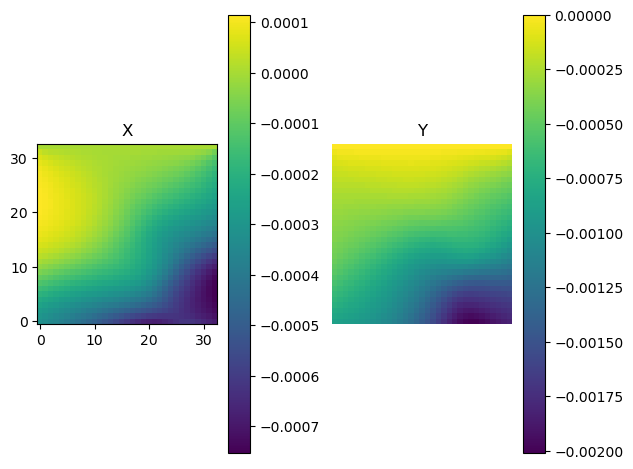

In [10]:
problem.Solve('direct')
problem.PlotField(2)

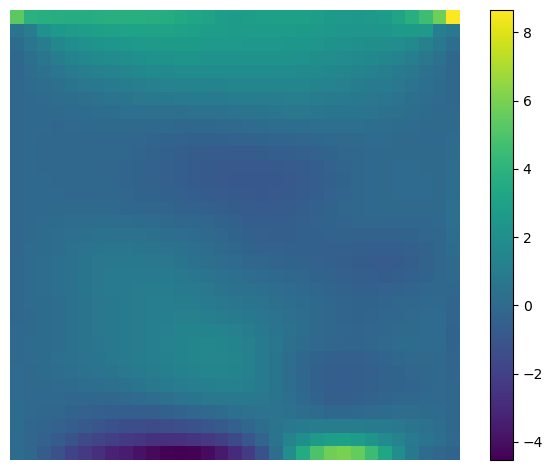

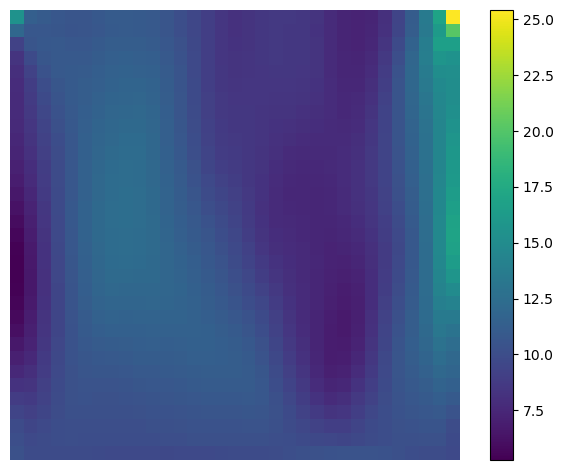

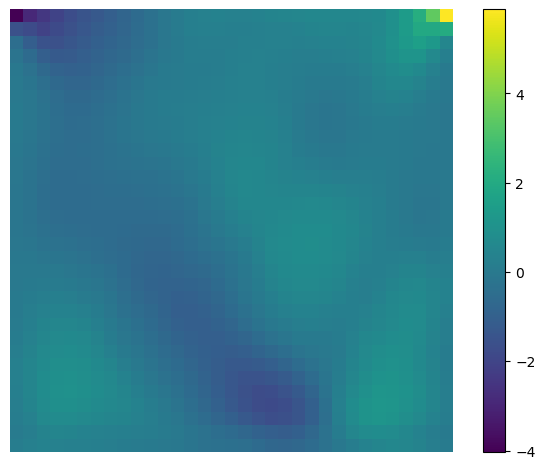

In [11]:
problem.ComputeStrainStress()
problem.PlotField(1, problem.stress[:,0])
problem.PlotField(1, problem.stress[:,1])
problem.PlotField(1, problem.stress[:,2])

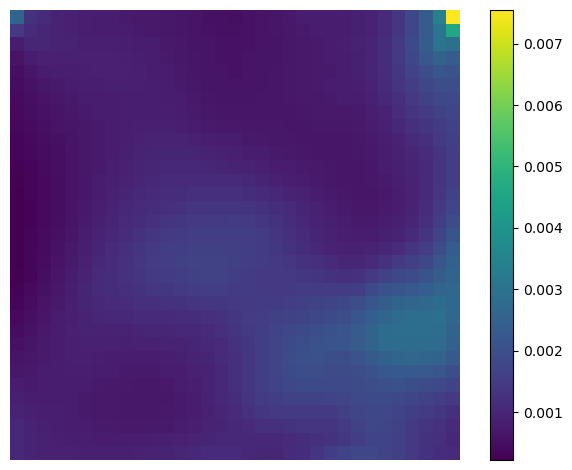

In [12]:
problem.ComputeStrainEnergyDensity()
problem.PlotField(1, problem.strain_energy_density)

#### Create dataset

In [13]:
def conn_list2array(node_mask, conn_list):
    '''Convert a connection list into nparrays '''
    h, w = node_mask.shape
    conn_array = np.zeros((h,w,len(conn_list)))
    for i in range(len(conn_list)):
        conn_len = conn_list[i].shape[0]
        subarray = np.full((h*w),-1) 
        subarray[:conn_len] = conn_list[i][:,0]
        subarray[conn_len] = conn_list[i][-1,1]
        conn_array[:,:,i] = subarray.reshape((h,w))
    return conn_array

In [14]:
dataset = {}
dirich_idx_data = np.zeros((n_test_data, h+1, w+1, 2))
dirich_value_data = np.zeros((n_test_data, h+1, w+1, 2))
traction_idx_data = np.zeros((n_test_data, h+1, w+1, 2*nneumann))
traction_value_data = np.zeros((n_test_data, h+1, w+1, 2*nneumann))
tranction_conn_data = np.zeros((n_test_data, h+1, w+1, nneumann))
node_mask_data = np.zeros((n_test_data, h+1, w+1, 1))
elem_mask_data = np.zeros((n_test_data, h, w, 1))
material_data = np.zeros((n_test_data, h, w, 2))
f_data = np.zeros((n_test_data, h+1, w+1, 2))
u_data = np.zeros((n_test_data, h+1, w+1, 2))
for i in range(n_test_data):
    dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val, neumann_connlist = loading_type1(node_mask, bc)
    problem = ElasticFEM2D(mesh, mode, material, dirich_val, neumann_val, f_val)    
    problem.Solve()
    material_data[i] = material*elem_mask.reshape(h,w,1)
    elem_mask_data[i,:,:,0] = elem_mask
    dirich_idx_data[i] = dirich_idx_feanet
    dirich_value_data[i] = dirich_val
    traction_idx_data[i] = neumann_idx
    traction_value_data[i] = neumann_val
    tranction_conn_data[i] = conn_list2array(node_mask, neumann_connlist)
    f_data[i] = f_val
    u_data[i] = problem.d.reshape((h+1, w+1, 2))
    print("Problem #-"+str(i)+" solved")

    # create mask images
    mask = np.zeros(((h+1)*(w+1),))
    mask[mesh.valid_node] = 1
    node_mask_data[i] = mask.reshape((h+1,w+1,1))

print("Generating the dataset ...")
dataset['elem_mask'] = elem_mask_data
dataset['node_mask'] = node_mask_data
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['neumann_idx'] = traction_idx_data
dataset['neumann_value'] = traction_value_data
dataset['neumann_conn'] = tranction_conn_data
dataset['material'] = material_data
dataset['source'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item

Problem #-0 solved
Generating the dataset ...
